# Time series analysis

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statistics
from sklearn import datasets
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

%matplotlib inline

We'll preview the dataset numerically and graphically.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head(15)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


<AxesSubplot:xlabel='Month'>

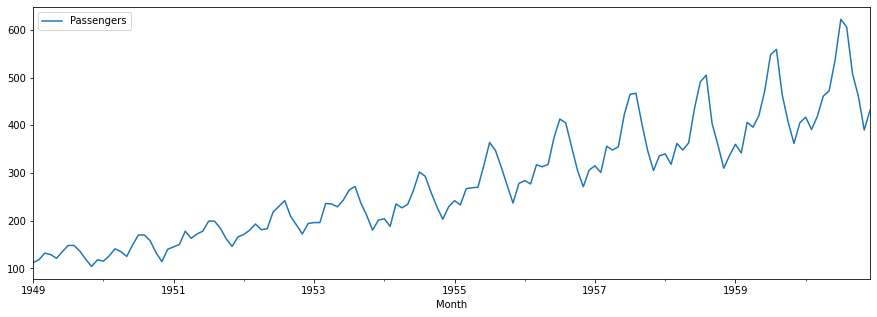

In [3]:
data.plot(figsize=(15, 5))

We'll use the last two years' data as the test set, to see if our forecasting is accurate. We'll then visualize the result.

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

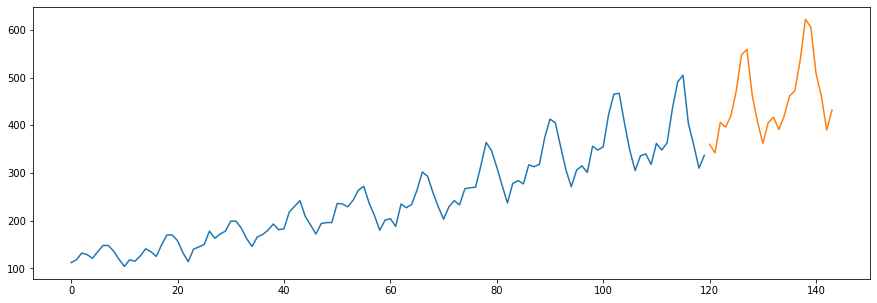

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

## 1 Time series decomposition

### 1.1 Heteroscedasticity

This time series' heteroscedasticity is evident, since the variance augments with time. This can be validated with tests like Breusch-Pagan's, but in this case it is confirmed only visually.

We'll visualize different transformation options to the original dataset to eliminate this heteroscedasticity effect and choose the right one.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> transforma los datos para eliminar la heterocedasticidad. Para ello debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

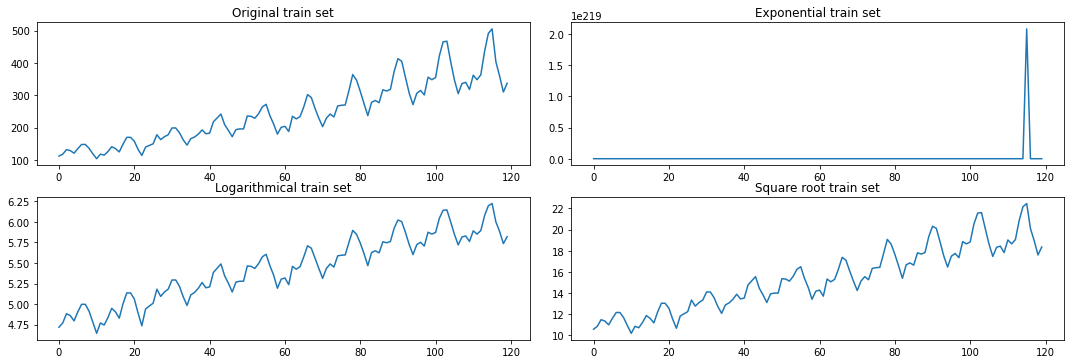

In [6]:
# Exponential transformation

data_exp = np.exp(train)

# Logarithmic transformation

data_log = np.log(train)

# Square root transformation

data_sqrt = np.sqrt(train)

# Plots

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
fig.tight_layout()
ax[0,0].plot(train)
ax[0,0].title.set_text('Original train set')
ax[0,1].plot(data_exp)
ax[0,1].title.set_text('Exponential train set')
ax[1,0].plot(data_log)
ax[1,0].title.set_text('Logarithmical train set')
ax[1,1].plot(data_sqrt)
ax[1,1].title.set_text('Square root train set')

The logarithmical transformation looks better than the square root. We'll compare the variances they give and choose the one with the lowest.

In [7]:
# Obtención varianzas

var_log = "{:.2f}".format(float(np.var(data_log)))
var_sqrt = "{:.2f}".format(float(np.var(data_sqrt)))

print("Log var = " + str(var_log) + ", sqrt var = " 
      + str(var_sqrt) +".")

Log var = 0.15, sqrt var = 8.89.


### 1.2. Trend

This series has an upward trend. This will be eliminated through a linear regression that will give the measure of how much we have to substract to the original series.

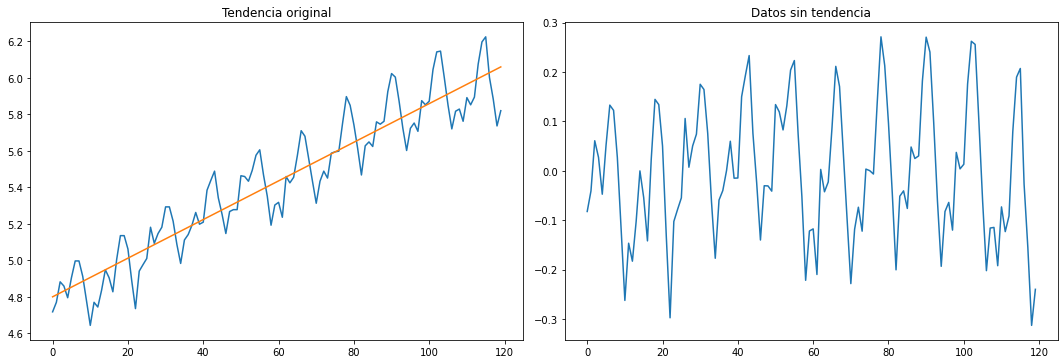

In [8]:
# Regression

X = [i for i in range(0, len(data_log))]
X = np.reshape(X, (len(X), 1))
y = data_log
model = LinearRegression()
model.fit(X, y)

# Trend obtention

trend = model.predict(X)

# Trend elimination

data_detrended = [y[i]-trend[i] for i in range(0, len(y))]


# Plots

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout()
ax[0].plot(y)
ax[0].plot(trend)
ax[0].title.set_text('Tendencia original')
ax[1].plot(data_detrended)
ax[1].title.set_text('Datos sin tendencia')

### 1.3 Seasonality

Seasonality is the cyclical variation of the time series with a constant period. In order to remove it we have to detect the period, and calculate it before its elimination.

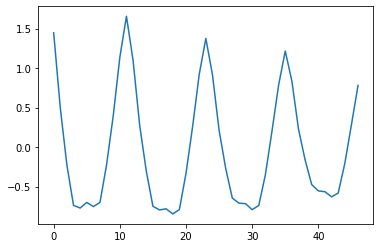

In [9]:
# Period detection

flat_list = [item for array in data_detrended for item in array]
detrended = np.array(flat_list)
result = [np.correlate(detrended[i:],detrended[:-i]) for i in range(1,48)]

# Plot

plt.plot(result)
plt.show()

We see a hike of the series that occurs every 12 months, and therefore the period is a whole year. We can further confirm this calculating the median value per month for the whole series.

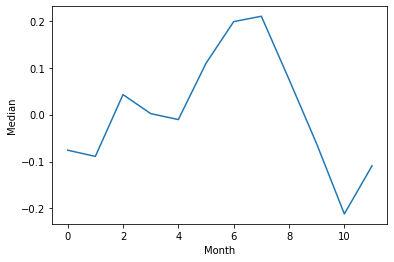

In [10]:
# Detrended median

nums = []
medians = []
to_calculate = []

for n in range(12):
    nums = list(range(n, ((n)+12*10), 12))
    for num in nums:
        to_calculate.append(detrended[num])
    medians.append(statistics.median(to_calculate))
    to_calculate = []
    
# Plot  
    
plt.xlabel('Month')
plt.ylabel('Median')
plt.plot(medians)
plt.show()

This graph represents the median seasonality. Let's now superpose it to the actual detrended data.

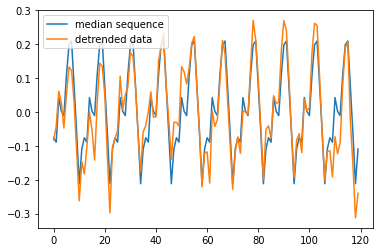

In [11]:
# 10-time replication of the median

medians_replicated = 10*(medians)

# Plot

plt.figsize=(15, 5)
plt.plot(medians_replicated, label = 'median sequence')
plt.plot(data_detrended, label = 'detrended data')
plt.legend(loc="upper left")

plt.show()

We see how the difference between these two series is not big. Let's remove seasonality from the detrended data and see how they are after that transformation. 

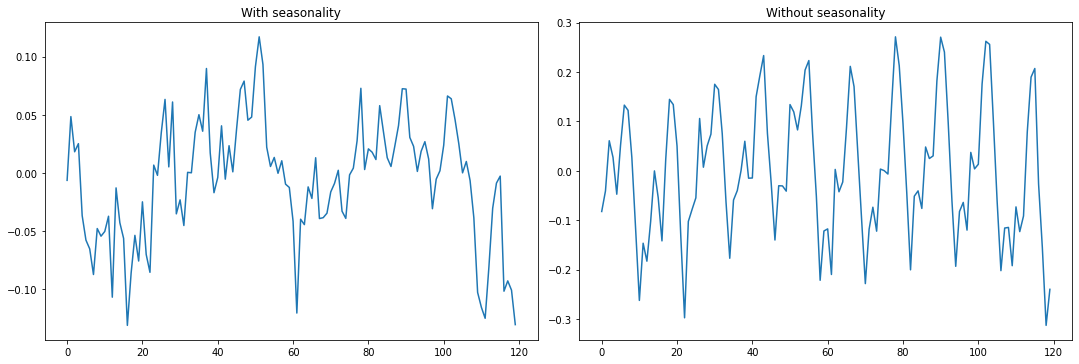

In [12]:
# Seasonality removal

data_deseasoned_ = [x1 - x2 for (x1, x2) in zip(data_detrended, medians_replicated)]
data_deseasoned = [item for array in data_deseasoned_ for item in array]

# Plots

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout()
ax[0].plot(data_deseasoned)
ax[0].title.set_text('With seasonality')
ax[1].plot(data_detrended)
ax[1].title.set_text('Without seasonality')

### 1.4 Noise

At this point, the data might only be Gaussian noise, i.e. a sequence of random values. If that is the case, it would follow a normal distribution. Let's see if that is the case here.

In [13]:
# Basic statistical features

results = scipy.stats.describe(data_deseasoned)
print(results)

DescribeResult(nobs=120, minmax=(-0.13127004881484305, 0.1170173871440765), mean=-0.006564023427129021, variance=0.002749734073868744, skewness=-0.3337859730510264, kurtosis=-0.1314021898831359)


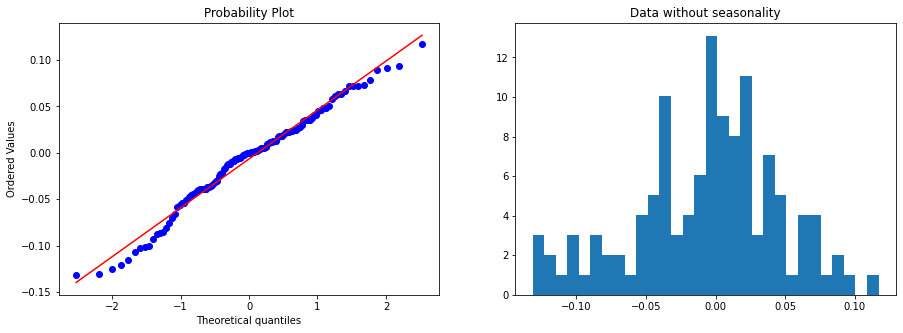

In [14]:
# Plots

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
res = scipy.stats.probplot(data_deseasoned, plot=plt)

ax2 = plt.subplot(122)
ax2 = plt.hist(data_deseasoned, density=True, bins=30)
ax2 = plt.title('Data without seasonality')
plt.show()

We can assume the data follows a Gaussian distribution.

## 1.2. Prediction

We can now try to predict the data from the 2 years initially removed. For that, the following process will be followed:

   - Noise generation
   - Seasonality addition
   - Trend addition
   - Heteroscedasticity addition

### 1.2.1. Noise

Some random noise will be generated for the last 24 months.

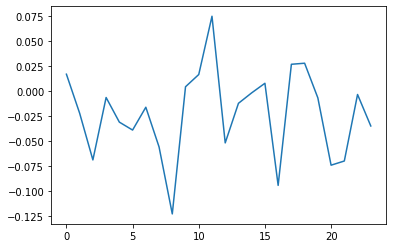

In [15]:
# Random data generation from the basic statistical features calculated before

mu = results[2]
sigma = np.sqrt(results[3])
new_data = np.random.normal(mu, sigma, 24)
plt.plot(new_data)
plt.show()

### 1.2.2. Seasonality

We'll re-use the seasonality we had substracted previously to add it to the new random time series.

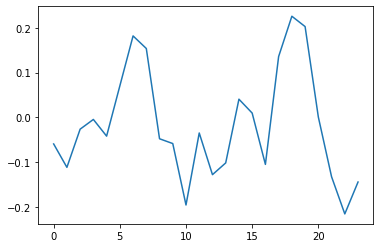

In [16]:
# Seasonality addition

medians_two_years = 2*(medians)
data_reseasoned = [x1 + x2 for (x1, x2) in zip(new_data, medians_two_years)]
plt.plot(data_reseasoned)
plt.show()

### 1.2.3. Trend

We'll do the same we've done for seasonality for the trend.

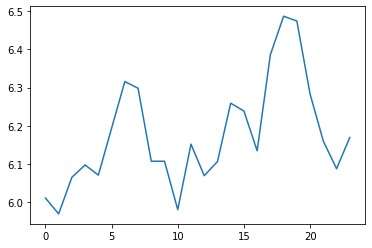

In [17]:
# Previous trend extension

slope = trend[2] - trend[1]    
lastval = trend[119]
trend_2 = np.arange((lastval + slope), (lastval + slope*25), slope)

# Trend addition

data_retrended = [data_reseasoned[i] +trend_2[i] for i in range(0, len(data_reseasoned))]

# Plot

plt.plot(data_retrended)
plt.show()

### 1.2.4. Heteroscedasticity

We'll now add the heteroscedasticity to finish the prediction.

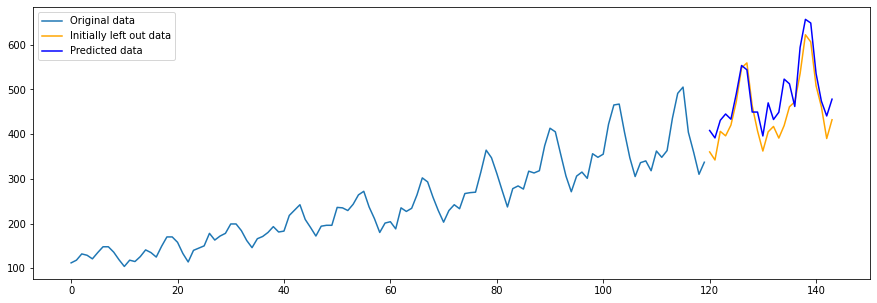

In [18]:
# Inverse log applied to the time series

new_data = np.exp(data_retrended)

# Plot

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train, label = 'Original data')
ax.plot(x_test, test, color = 'Orange', label = 'Initially left out data')
ax.plot(x_test, new_data, color = 'Blue', label = 'Predicted data')
plt.legend(loc="upper left")
plt.show()

We see how this data matches the original time series' pattern. 

### 1.2.5. Prediction interval

We'll now generate a prediction interval for the time series' last two years. To do so, we'll repeat the process of creating an artificial time series 500 times and see which are the upper and lower limits of this prediction. The most extreme values for each month will be kept, to ensure the prediction interval reflects the limits of what could be predicted with this method.

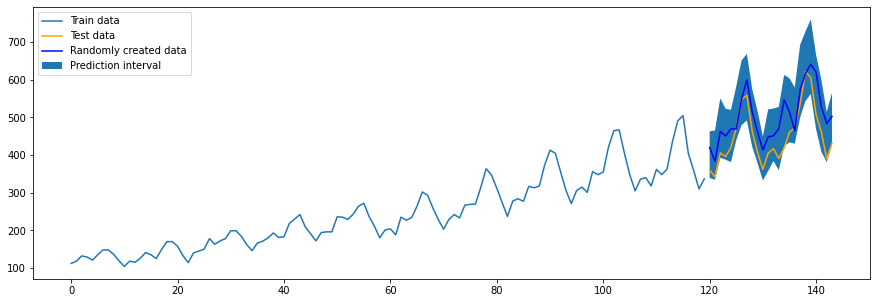

In [19]:
generated = []

for i in range(500):
    new_data = np.random.normal(mu, sigma, 24)
    data_reseasoned = [x1 + x2 for (x1, x2) in zip(new_data, medians_two_years)]
    data_retrended = [data_reseasoned[i] +trend_2[i] for i in range(0, len(data_reseasoned))]
    new_data = np.exp(data_retrended)
    generated.append(new_data)
    
base = generated[0]
min_ = base.tolist()
max_ = base.tolist()
    
for j in range(500):
    for i in range(24):
        if (min_[i] > generated[j][i]):
            min_[i] =  generated[j][i]
        if (max_[i] < generated[j][i]):
            max_[i] =  generated[j][i]   
            

# Plot

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train, label = 'Train data')
ax.plot(x_test, test, color = 'Orange', label = 'Test data')
ax.plot(x_test, new_data, color = 'Blue', label = 'Randomly created data')
ax.fill_between(x_test, min_, max_, label = 'Prediction interval')
plt.legend(loc="upper left")
plt.show()

### Bibliography

1. https://python.plainenglish.io/heteroscedasticity-analysis-in-time-series-data-fee51503cc0e
2. https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/
3. https://machinelearningmastery.com/time-series-trends-in-python/
4. https://stackoverflow.com/questions/8194156/how-to-subtract-two-lists-in-python
5. https://www.kaggle.com/code/nithinma/white-noise-in-timeseries